<a href="https://colab.research.google.com/github/thakurhrutika/NNDL-LAB/blob/main/Practical_2(b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**PRACTICAL 2**

**b] Aim :** To implement flower image classification using cnn.

**Problem Statement**:

We all come across numerous flowers on a daily basis. But we don’t even know their names at times. We all wonder “I wish my computer/mobile could classify this” when we come across a beautiful looking flower. That is the motive behind this is to classify flower images.
The main objective of this article is to use Convolutional Neural Networks (CNN) to classify flower images into 10 categories.



**Implementation**

In [ ]:

!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Flower_Color.zip

--2022-05-01 08:52:27--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Flower_Color.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.95
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52779776 (50M) [application/x-zip-compressed]
Saving to: ‘Flower_Color.zip’

Flower_Color.zip    100%[===================>]  50.33M  10.2MB/s    in 5.9s    

2022-05-01 08:52:34 (8.58 MB/s) - ‘Flower_Color.zip’ saved [52779776/52779776]



In [ ]:
!unzip -qo Flower_Color.zip

**Import Libraries**

In [ ]:
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import PReLU, LeakyReLU
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

**Data Preprocessing**

In [ ]:
def image_to_tensor(img_path):
    img = keras_image.load_img("Flower Color/flower_images/" + img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

In [ ]:
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv("Flower Color/flower_images/flower_labels.csv")
files = data['file']
targets = data['label'].values
tensors = data_to_tensor(files);

100%|██████████| 210/210 [00:00<00:00, 326.40it/s]


In [ ]:
data.head()

,file,label
0,0001.png,0
1,0002.png,0
2,0003.png,2
3,0004.png,0
4,0005.png,0


In [ ]:
tensors.shape

(210, 128, 128, 3)

In [ ]:
targets.shape

(210,)

In [ ]:
# Name list
names = ['phlox', 'rose', 'calendula', 'iris', 'max chrysanthemum', 
         'bellflower', 'viola', 'rudbeckia laciniata', 'peony', 'aquilegia']

**Display sample images**

In [ ]:
def display_images(img_path, ax):
    img = cv2.imread("Flower Color/flower_images/" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

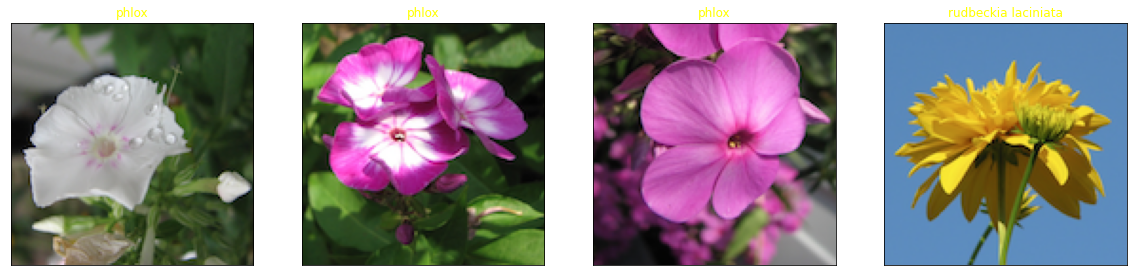

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i in range(4):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.set_title(names[targets[i+10]], color='yellow')
    display_images(files[i+10], ax)


**Save data in h5 file for future use**

In [ ]:
# Create h5 file and save data
with h5py.File('FlowerColorImages.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.close()

In [ ]:
# Read the h5 file
f = h5py.File('FlowerColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['images', 'labels']

**Create tensors and targets**

In [ ]:
tensors = np.array(f[keys[0]])
targets = np.array(f[keys[1]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (210, 128, 128, 3)
Target shape (210,)


In [ ]:
# Create a csv file and save data
images_csv = tensors.reshape(210,128*128*3)
np.savetxt("flower_images.csv", images_csv, fmt='%i', delimiter=",")

In [ ]:
# Read the pandas dataframe from csv
data_images = pd.read_csv("flower_images.csv", header=None)
data_images.head()

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,13,22,10,14,23,9,16,24,10,16,...,44,59,38,38,26,25,16,117,74,78
1,38,49,30,37,50,30,38,52,30,40,...,9,9,10,8,7,7,7,5,5,5
2,65,83,48,72,87,58,74,90,62,81,...,35,52,70,38,56,74,41,58,76,42
3,162,53,102,147,66,91,156,80,97,169,...,69,105,44,67,103,43,68,103,43,68
4,193,52,78,194,51,76,195,58,85,197,...,199,253,179,200,248,163,189,229,120,154


In [ ]:
data_images.iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
0,13,22,10,14,23,9,16,24,10,16
1,38,49,30,37,50,30,38,52,30,40
2,65,83,48,72,87,58,74,90,62,81
3,162,53,102,147,66,91,156,80,97,169
4,193,52,78,194,51,76,195,58,85,197
5,53,76,55,53,76,55,53,77,56,53
6,8,9,8,8,9,9,9,9,9,8
7,9,9,8,9,9,9,8,8,8,8
8,195,127,169,188,118,160,135,76,101,55
9,7,7,7,8,7,7,8,9,8,9


In [ ]:
data_images.shape

(210, 49152)

In [ ]:
# Read image tensors from the dataframe
tensors = data_images.values
tensors.shape

(210, 49152)

In [ ]:
tensors = tensors.reshape(-1,128,128,3)
tensors.shape

(210, 128, 128, 3)

**Normalize the tensors**

In [ ]:
tensors = tensors.astype('float32')/255

**One-hot encode the targets**

In [ ]:
targets = to_categorical(targets, 10)

**Split the data**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tensors, targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [ ]:
x_train.shape, y_train.shape

((168, 128, 128, 3), (168, 10))

In [ ]:
x_test.shape, y_test.shape

((21, 128, 128, 3), (21, 10))

In [ ]:
 x_valid.shape, y_valid.shape

((21, 128, 128, 3), (21, 10))

Label:  rose


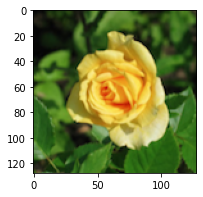

In [ ]:
# Read and display a tensor
print('Label: ', names[np.argmax(y_train[7])])
plt.figure(figsize=(3,3))
plt.imshow((x_train[7]));

**Define Model and Train**

In [ ]:
def model():
    model = Sequential()

    model.add(Conv2D(128, (3, 3), input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()

In [ ]:
# To save the best model
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)

# To reduce learning rate dynamically
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.2)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 61, 61, 128)       0         
                                                      

**Train the model**

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs=75, batch_size=32, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer,lr_reduction])

Epoch 1/75

Epoch 1: val_loss improved from inf to 2.29416, saving model to weights.best.model.hdf5
6/6 - 18s - loss: 2.3592 - accuracy: 0.0774 - val_loss: 2.2942 - val_accuracy: 0.0476 - lr: 0.0010 - 18s/epoch - 3s/step
Epoch 2/75

Epoch 2: val_loss improved from 2.29416 to 2.26846, saving model to weights.best.model.hdf5
6/6 - 18s - loss: 2.2632 - accuracy: 0.1607 - val_loss: 2.2685 - val_accuracy: 0.2857 - lr: 0.0010 - 18s/epoch - 3s/step
Epoch 3/75

Epoch 3: val_loss improved from 2.26846 to 2.23260, saving model to weights.best.model.hdf5
6/6 - 16s - loss: 2.1895 - accuracy: 0.2083 - val_loss: 2.2326 - val_accuracy: 0.1905 - lr: 0.0010 - 16s/epoch - 3s/step
Epoch 4/75

Epoch 4: val_loss improved from 2.23260 to 2.18152, saving model to weights.best.model.hdf5
6/6 - 18s - loss: 2.0601 - accuracy: 0.2798 - val_loss: 2.1815 - val_accuracy: 0.2381 - lr: 0.0010 - 18s/epoch - 3s/step
Epoch 5/75

Epoch 5: val_loss improved from 2.18152 to 2.05777, saving model to weights.best.model.hdf5


**Train the model with image generation**

In [ ]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)

dg_history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                 steps_per_epoch = len(x_train)//64, epochs=7, verbose=2, 
                                 validation_data=(x_valid, y_valid),
                                 callbacks=[checkpointer,lr_reduction])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/7

Epoch 1: val_loss did not improve from 0.60820
2/2 - 14s - loss: 0.4198 - accuracy: 0.8516 - val_loss: 0.6220 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 14s/epoch - 7s/step
Epoch 2/7

Epoch 2: val_loss did not improve from 0.60820
2/2 - 11s - loss: 0.5533 - accuracy: 0.8077 - val_loss: 0.6220 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 11s/epoch - 5s/step
Epoch 3/7

Epoch 3: val_loss did not improve from 0.60820
2/2 - 14s - loss: 0.4519 - accuracy: 0.8438 - val_loss: 0.6220 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 14s/epoch - 7s/step
Epoch 4/7

Epoch 4: val_loss did not improve from 0.60820
2/2 - 13s - loss: 0.5314 - accuracy: 0.8047 - val_loss: 0.6220 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 13s/epoch - 7s/step
Epoch 5/7

Epoch 5: val_loss did not improve from 0.60820
2/2 - 13s - loss: 0.4965 - accuracy: 0.8047 - val_loss: 0.6221 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 13s/epoch - 7s/step
Epoch 6/7

Epoch 6: val_loss did not improve from 0.60820

Epoch 6: ReduceLROnPlateau

In [ ]:
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')

**Model Evaluation**

In [ ]:
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

1/1 [==============================] - 1s 578ms/step - loss: 0.7395 - accuracy: 0.7619


[0.7394840717315674, 0.761904776096344]

In [ ]:
# Calculate classification accuracy on the training set
score = model.evaluate(x_train, y_train)
score

6/6 [==============================] - 4s 711ms/step - loss: 0.4157 - accuracy: 0.9167


[0.41570818424224854, 0.9166666865348816]

In [ ]:
# Calculate classification accuracy on the validation set
score = model.evaluate(x_valid, y_valid)
score

1/1 [==============================] - 1s 576ms/step - loss: 0.6082 - accuracy: 0.9524


[0.6081967949867249, 0.9523809552192688]

**Accuracy Plot**

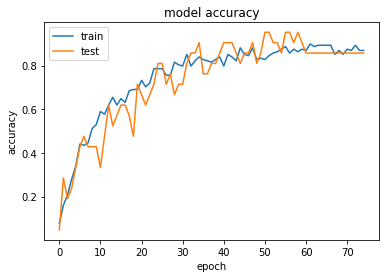

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Loss plot**

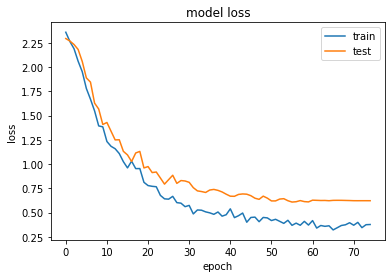

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
model1 = load_model('model.h5')

**Predictions**

In [ ]:
# Model predictions for the testing dataset
y_test_predict = model1.predict(x_test)

In [ ]:
y_test_predict = np.argmax(y_test_predict,axis=1)

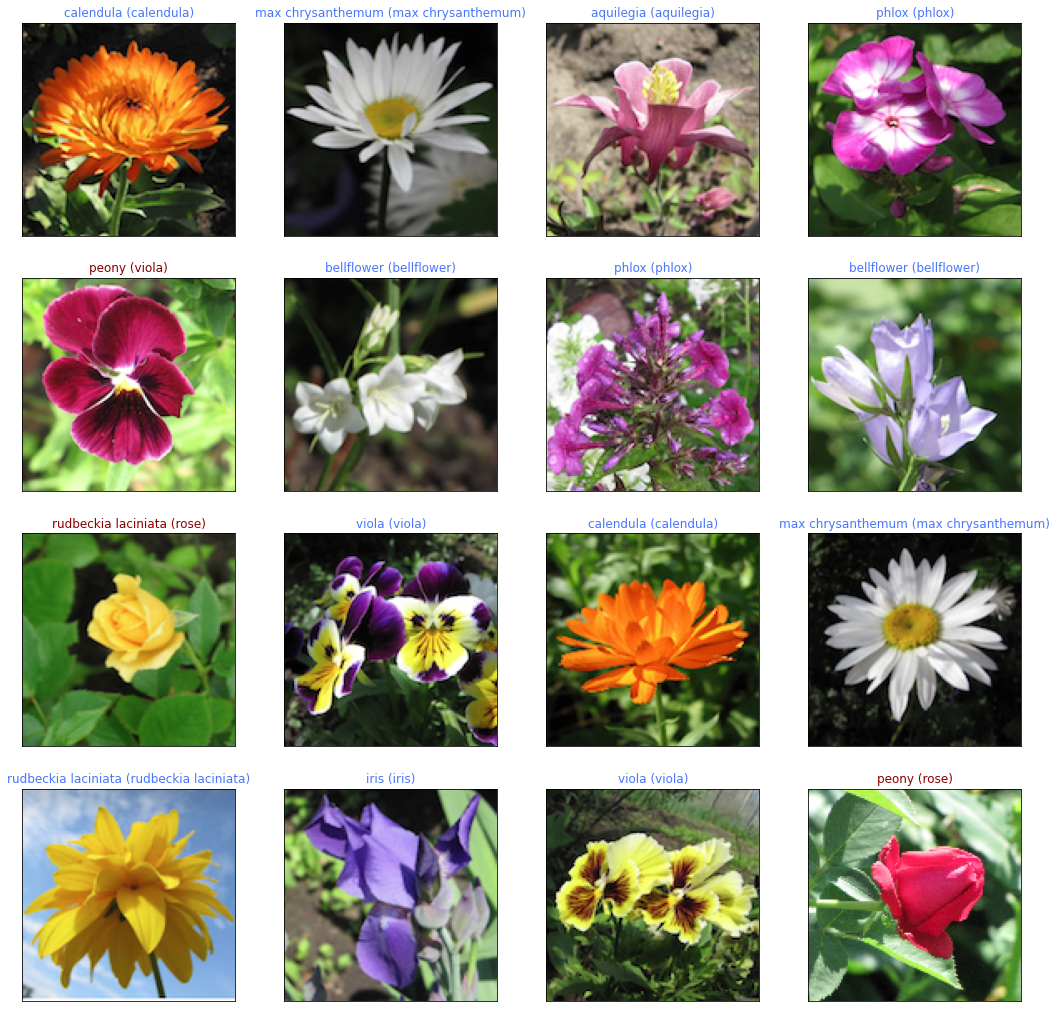

In [ ]:
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))

**Plot Confusion Matrix**

In [ ]:
y_test_orig = []

In [ ]:
for i in y_test:
  y_test_orig.append(np.argmax(i)) 

In [ ]:
y_test_orig = np.array(y_test_orig)

In [ ]:
y_test_orig

array([6, 3, 4, 9, 2, 0, 7, 6, 1, 2, 4, 0, 6, 0, 3, 1, 6, 5, 5, 7, 1])

In [ ]:
y_test_predict

array([6, 5, 4, 9, 2, 0, 7, 8, 8, 2, 4, 8, 6, 0, 3, 7, 6, 5, 5, 7, 1])

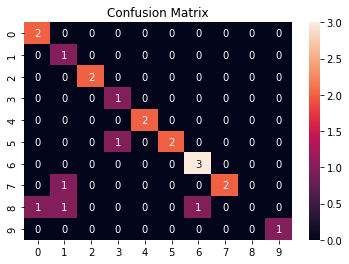

In [ ]:
#Plotting a confusion matrix
cnf = confusion_matrix(y_test_predict,y_test_orig)


df_cnf = pd.DataFrame(cnf, range(10), range(10))
sns.heatmap(df_cnf, annot = True)
plt.title("Confusion Matrix")
plt.show()

**DeepCC**

In [ ]:
!deepCC model.h5

/bin/bash: deepCC: command not found


**Conclusion:** We have successfully implemented flower image classification using cnn.